In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import gc
import os
import pickle
import sklearn
import sys

from sklearn.preprocessing import MultiLabelBinarizer
from joblib import Parallel, delayed
from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 1

In [2]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../src')
sys.path.append(src_dir)

In [3]:
%aimport data.delicious_t140
%aimport helpers.labels
%aimport features.delicious_t140

In [4]:
from data.delicious_t140 import (get_full_from_cache)
from helpers.labels import truncate_labels
from features.delicious_t140 import clean_text_delicious

In [5]:
INTERIM_DATA_ROOT = os.path.abspath("../../data/interim/delicious-t140/")

DATA_ROOT = "/media/felipe/SAMSUNG/delicious/delicioust140/"
TAGINFO=DATA_ROOT+"/taginfo.xml"

In [6]:
docs_df = get_full_from_cache(INTERIM_DATA_ROOT,with_contents=False)

## number of documents

In [10]:
len(docs_df)

143716

In [11]:
docs_df.head()

,filename,filetype,hash,tags,url,num_users,num_tags
0,3d647dfac66aa9d81ba026d1d7828a82.html,html,3d647dfac66aa9d81ba026d1d7828a82,"libertarianism,economics,marxism,politics,blog...",http://mutualist.blogspot.com/2005/01/vulgar-l...,9,8
1,7ad6f307f999cbee5d5629dc10ffbb47.html,html,7ad6f307f999cbee5d5629dc10ffbb47,"wiki,search,wikipedia,rpg,writing,database,com...",http://rpg.wikia.com/wiki/RPG,5,9
2,bf4569fee0b3f791fb0a429715e5609f.html,html,bf4569fee0b3f791fb0a429715e5609f,"panicatthedisco,patd,au,ryanbrendon,nc-17,pani...",http://community.livejournal.com/we_are_cities...,35,12
3,f5c23722301a1b1ad8ccbd33bb08fb88.html,html,f5c23722301a1b1ad8ccbd33bb08fb88,"gadget,music,ipod,media,software,flac,shopping...",http://www.cowonglobal.com/,161,22
4,814d894e5880d8268acb2632a31311a1.html,html,814d894e5880d8268acb2632a31311a1,"sockets,networking,software,documentation,fram...",http://twistedmatrix.com/projects/core/documen...,136,25


In [12]:
docs_df.describe(include=['number'])

,num_users,num_tags
count,143716.000000,143716.000000
mean,182.584750,13.116904
std,663.493158,8.057152
min,1.000000,1.000000
25%,13.000000,6.000000
50%,35.000000,11.000000
75%,122.000000,22.000000
max,46215.000000,25.000000


In [13]:
docs_df.describe(include=['object'])

,filename,filetype,hash,tags,url
count,143716,143716,143716,143716,143716
unique,143716,1,143716,141813,143716
top,2bda5b1bc55daf17334eb7eb079ebe02.html,html,2d510ae055112c53e5c7c73a6281a76f,"food,recipes,cooking",http://www.freemacware.com/iphone-simulator/
freq,1,143716,1,37,1


In [14]:
labelsets = [tagset.split(',') for tagset in docs_df["tags"].values]

In [15]:
mlb = MultiLabelBinarizer(sparse_output=True)
tag_assignments = mlb.fit_transform(labelsets)

## number of tags per document

In [16]:
total_number_of_tags = len(mlb.classes_)
print("total number of unique tags: "+str(total_number_of_tags))

total number of unique tags: 9184


In [17]:
tags_per_document = tag_assignments.sum(axis=1)

In [18]:
tags_per_document.mean()

13.11537337526789

In [19]:
tags_per_document.max()

25

In [20]:
tags_per_document.min()

1

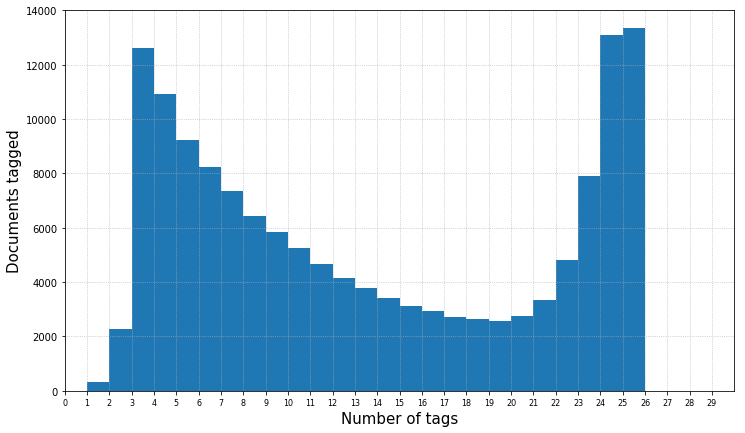

In [68]:
plt.hist(tags_per_document,bins=np.arange(1.0,30,1),rwidth=1.0)
plt.gcf().set_size_inches(12,7)
# plt.gca().set_title('Number of tags per document',fontsize=20)
plt.xlabel('Number of tags',fontsize=15)
plt.ylabel('Documents tagged', fontsize=15)
plt.gca().set_xlim(0,30)

plt.gca().grid(True)
gridlines = plt.gca().get_xgridlines() + plt.gca().get_ygridlines()
for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(0.7)

plt.setp(plt.gca().get_xticklabels(), fontsize=8)
plt.xticks(np.arange(0, 30, 1))
plt.show()

## number of times each tag was given to a movie
(not counting multiple assignments)

In [34]:
documents_per_tag = tag_assignments.sum(axis=0)

In [35]:
documents_per_tag.mean()

205.23617160278746

In [36]:
documents_per_tag.max()

26603

In [37]:
documents_per_tag.min()

10

In [38]:
documents_per_tag = np.array(documents_per_tag).ravel()

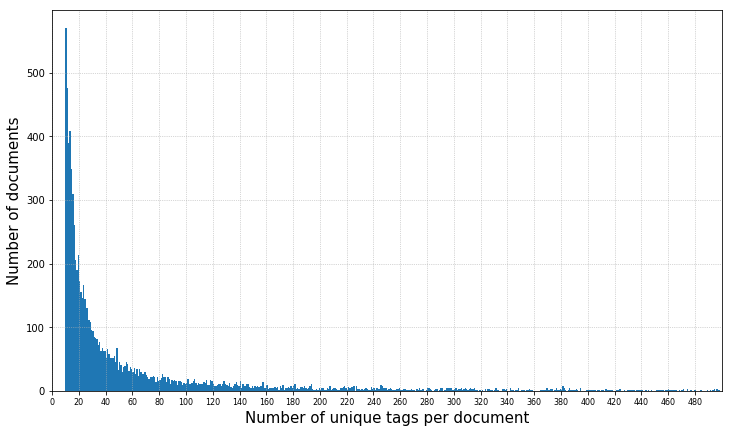

In [70]:
plt.hist(documents_per_tag,bins=np.arange(1.0,500,1),rwidth=1.0)

plt.gcf().set_size_inches(12,7)
# plt.gca().set_title('Number of tags per document',fontsize=20)
plt.gca().set_xlim(0,500)
plt.xlabel('Number of unique tags per document',fontsize=15)
plt.ylabel('Number of documents', fontsize=15)
plt.xticks(np.arange(0, 500, 20))

plt.gca().grid(True)
gridlines = plt.gca().get_xgridlines() + plt.gca().get_ygridlines()
for line in gridlines:
    line.set_linestyle(':')
    line.set_linewidth(0.7)

plt.setp(plt.gca().get_xticklabels(), fontsize=8)
plt.show()